# Задача

Вклеить изображение машины в транспортную сценцу, промасштабировав его и применив фильтры для корректного отображения

# Описание

В качетсве транспортной сцены используются изображения датасета CityScape
Для этого применяются следующие шаги 

1) На изображении находится дорога и машины

2) Горизон ставится "на глазок"

3) Выбирается горизонталь на которую ставить авто

4) Находится оптимальная машина для масштабирования, с нее снимаются параметры

5) По снятым параметрам масштабируется вкливаемое авто

6) Авто вклеивается в дорогу

7) Применяются фильтры и размытие

В папке car_proj лежат 5 фото и JSON для тестов подназвание frankfurt_1, frankfurt_2, frankfurt_3, frankfurt_4, frankfurt
для изменения файла следует поменять путь в переменных json_data в 1 блоке и road_img в 5 блоке

# Результат 
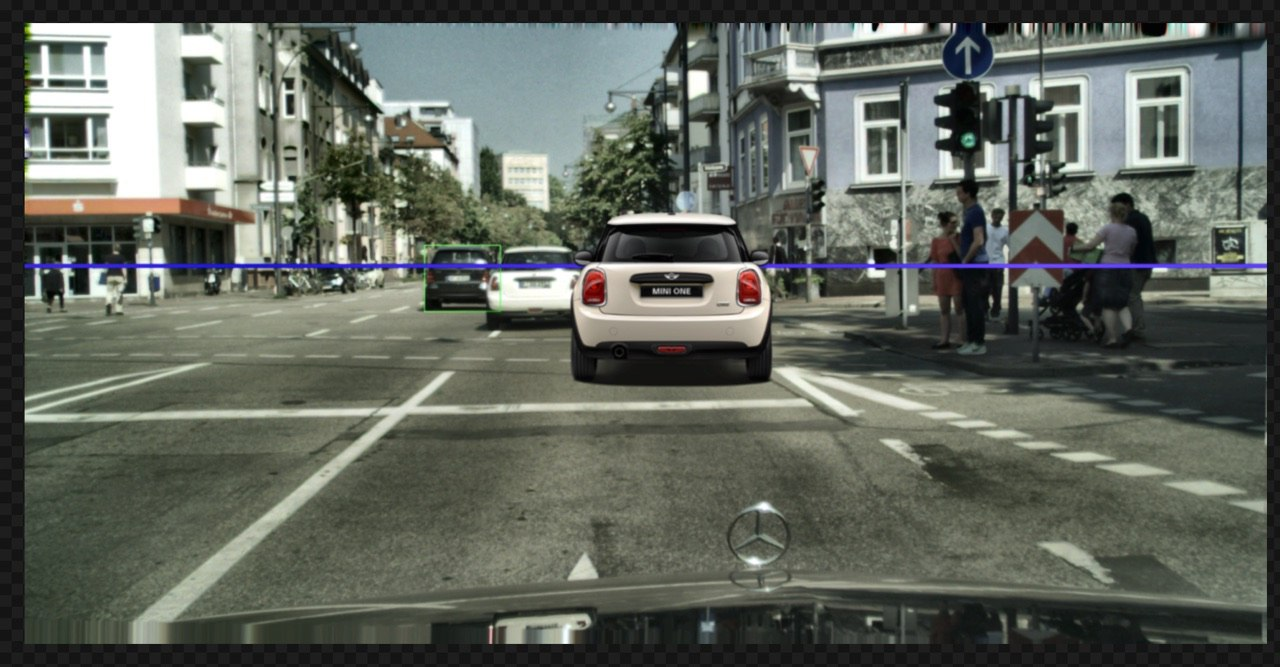
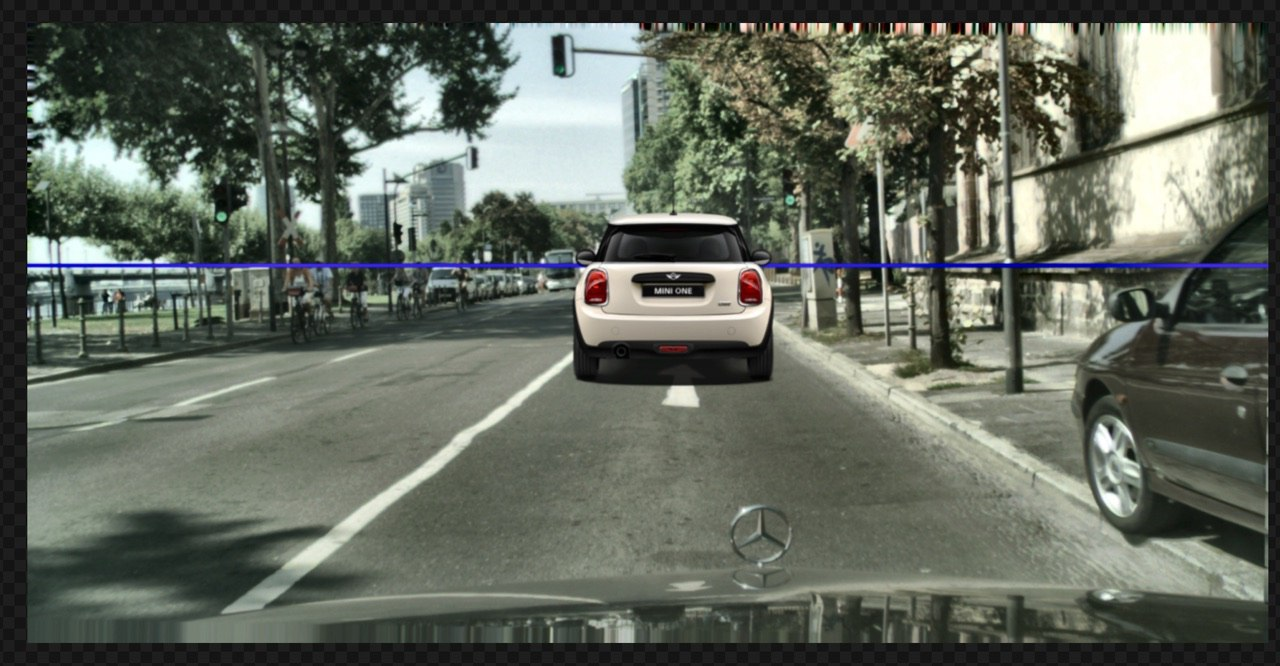
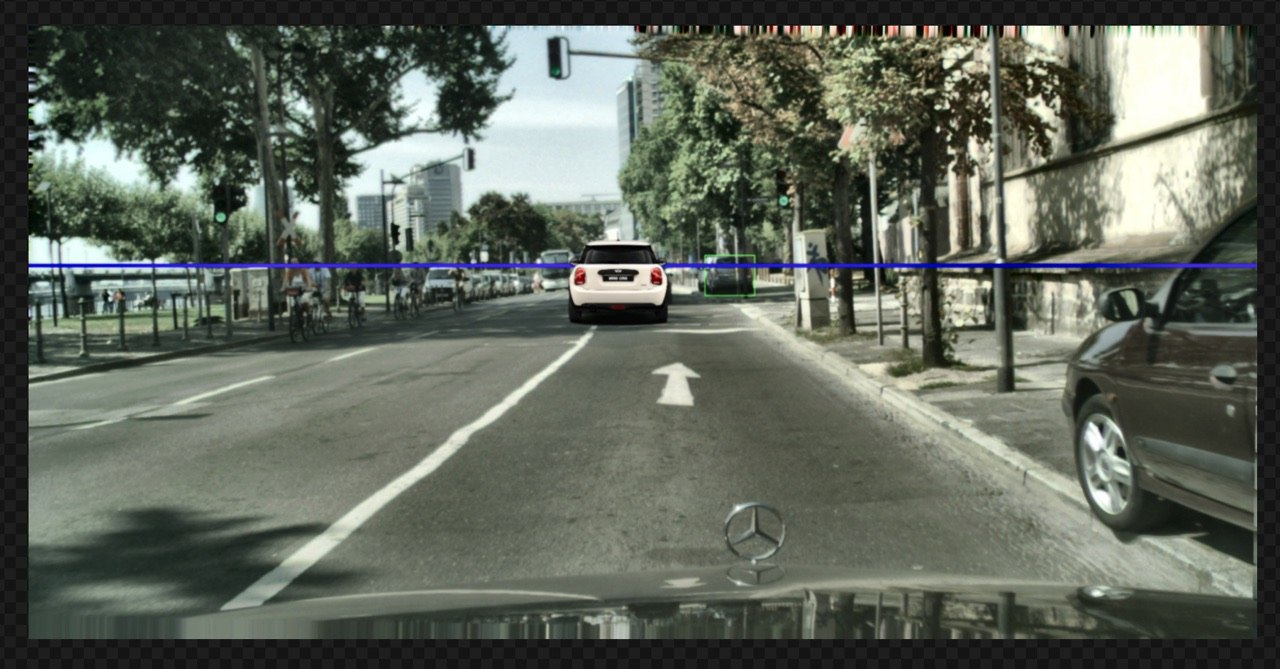
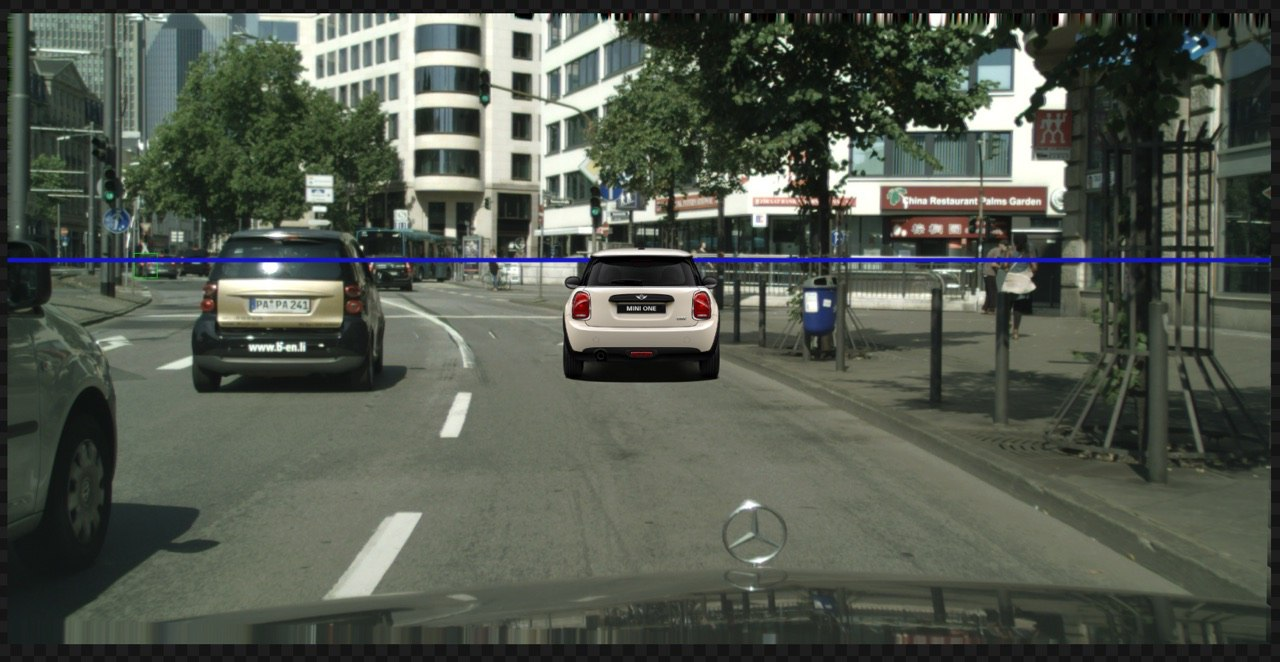

In [1]:
import json
#JSON для чтения сегментации
json_data = open("car_proj/frankfurt_3.json").read()
data = json.loads(json_data)
objects = data["objects"]

In [2]:
#метод для чтения полигона дороги из JSON
def getRoad():
    for object in objects:
        if (object["label"]=="road"):
            road = object["polygon"]
            break
    return road;

In [3]:
#метод для чтения полигонов машин
def getCars():
    cars = []
    for object in objects:
        if (object["label"]=="car"):
            cars.append(object["polygon"])
    return cars

In [4]:
import cv2
import numpy as np
import math
import random
from matplotlib import pyplot as plt
# библиотека используемая для нахождения точек пересечения между обЪектами
from shapely.geometry import LineString
import shapely.geometry as geometry
# переменная проставляющая  x для линии горизонта
HORIZEN = 400
# переменная проставляющая  x для горизонтали на которую ставится авто
horizontal = 500

GREEN = (33, 204, 41)

In [5]:
np.set_printoptions(threshold=np.nan)
#чтение изображений машины и дорожной сцены
car_img = cv2.imread("car_proj/back_view.png", cv2.IMREAD_UNCHANGED)
road_img = cv2.imread("car_proj/frankfurt_3.png", cv2.IMREAD_UNCHANGED)

In [6]:
#метод для нахождения пересечения дороги и горизонтали на которую ставится машина
def findRoadIntersection(choosenHorizontal):
    img_width= road_img.shape[1]
    road = getRoad()
    ans = []
    line = LineString([(0, choosenHorizontal),(img_width, choosenHorizontal)])
    polygon = []
    for point in road:
        polygon.append((point[0], point[1]))

    poly = geometry.Polygon(polygon)
    point = str(poly.intersection(line))
    if (point != "GEOMETRYCOLLECTION EMPTY"):
        arr = point.split("(")[1]
        arr = arr.replace(")","")
        arr = arr.replace(",", "")
        arr = arr.split(" ")
        point1 = (int(float(arr[0])), int(float(arr[1])))
        point2 = (int(float(arr[2])), int(float(arr[3])))
        # cv2.line(road_img, point1, point2, (0,0,255),2)

        print(point1, point2)

        return point1[0], point2[0]
    else:
        print("No free road on this horizontal")
        return False

In [7]:
#выбор машины для масштабирования
def rectCar():
    params = []
    cars = getCars()
    min_val = float('inf')
    min_index = 0
    for index in range(len(cars)):
        car = np.asarray(cars[index], np.int32)
        x, y, w, h = cv2.boundingRect(car)
        print(abs(w / h - 1))
        if abs(w / h - 1) < min_val and x > 200 and x < 1800:
            min_index = index
            min_val = abs(w / h - 1)
    car = np.asarray(cars[min_index], np.int32)
    x, y, w, h = cv2.boundingRect(car)
    print(min_index)

    distHoriz = y + h - HORIZEN
    car_width = w
    param = distHoriz / car_width
    params.append(param)
    cv2.rectangle(road_img, (x, y), (x + w, y + h), (0, 255, 0), 1)
    drawHorizon()
    print("param =", param)
    return param

In [8]:
#отрисовка линии горизонта - синяя линия на фото
def drawHorizon():
    img_height, img_width, img_channels = road_img.shape
    cv2.line(road_img, (0, 400), (img_width, 400), (200, 20, 20), 5)

In [9]:
# масштабирование машины
def getPerspectCar(param):
    h, w, channels = car_img.shape
    dist = horizontal - HORIZEN
    width = dist / param
    car_img_small = cv2.resize(car_img, (0, 0), fx=width / w, fy=width / w)

    return car_img_small


In [10]:
#клахи и размытие
def blurclahe(image):
    blur = cv2.GaussianBlur(image,(5,5),0)
    lab = cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    blur = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return blur

In [11]:
#вклейка машины в дорожную сцену
def drawCar():

    param = rectCar()
    car_img = getPerspectCar(param)
    x1, x2 = findRoadIntersection(horizontal)
    # x_offset = random.randint(x1, x2)
    x_offset = 900
    y_offset = horizontal - car_img.shape[0]

    y1, y2 = y_offset, y_offset + car_img.shape[0]
    x1, x2 = x_offset, x_offset + car_img.shape[1]

    alpha_s = car_img[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s
    
    global road_img

    for c in range(0, 3):
        road_img[y1:y2, x1:x2, c] = (alpha_s * car_img[:, :, c] + alpha_l * road_img[y1:y2, x1:x2, c])
        
    return blurclahe(road_img)

In [12]:
def toRGB(img):
    b, g, r= cv2.split(img)
    image_RGB = cv2.merge((r,g,b))
    return image_RGB



0.09375
0.07499999999999996
0.1200000000000001
0.34090909090909083
0.25806451612903225
0.21851851851851856
0.6732851985559567
1
param = 0.7837837837837838
(0, 500) (2048, 500)


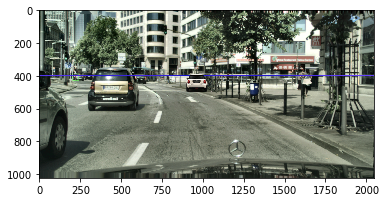

In [13]:
#__main__
road = drawCar()

cv2.imwrite("test.jpeg", road)
road = toRGB(road)
plt.imshow(road)

# 2 Способ (работает не оч)
он заключается в том, чтобы найти расстояние до объекта и по нему рассчитать размеры
формула для подсчета размера по дистанции
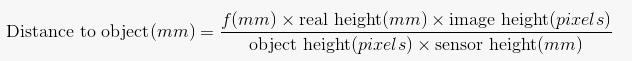 
подсчет дистанции по углу и высоте камеры
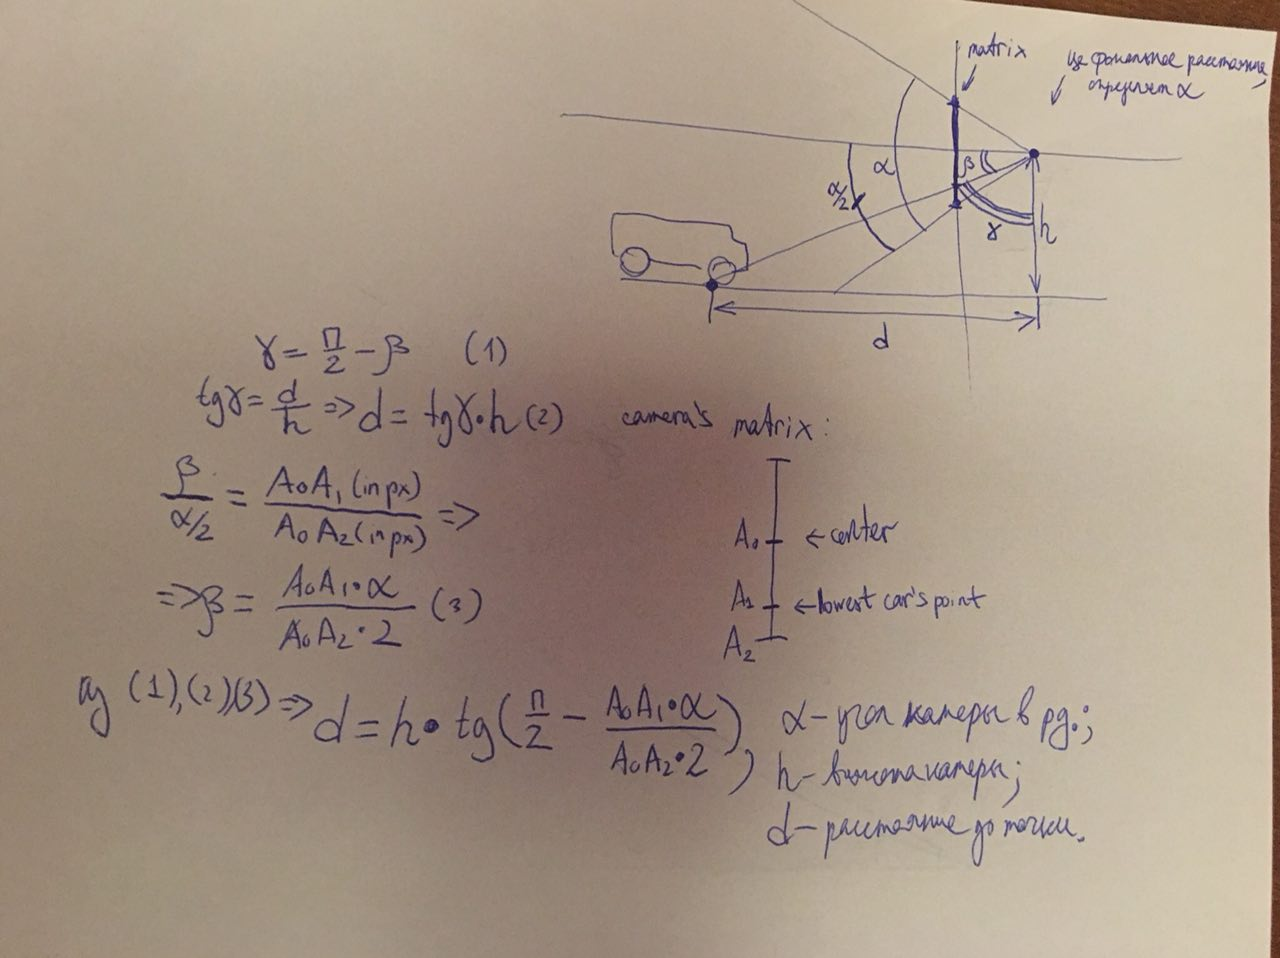

In [14]:
import json
#JSON для чтения сегментации
json_data = open("car_proj/frankfurt_3.json").read()
data = json.loads(json_data)
objects = data["objects"]

In [15]:
#метод для чтения полигона дороги из JSON
def getRoad():
    for object in objects:
        if (object["label"]=="road"):
            road = object["polygon"]
            break
    return road;

In [16]:
#метод для чтения полигонов машин
def getCars():
    cars = []
    for object in objects:
        if (object["label"]=="car"):
            cars.append(object["polygon"])
    return cars

In [27]:
import cv2
import numpy as np
import math
import random
from matplotlib import pyplot as plt
# библиотека используемая для нахождения точек пересечения между обЪектами
from shapely.geometry import LineString
import shapely.geometry as geometry
# переменная проставляющая  x для линии горизонта
HORIZEN = 400
# переменная проставляющая  x для горизонтали на которую ставится авто
horizontal = 600

GREEN = (33, 204, 41)

In [28]:
np.set_printoptions(threshold=np.nan)
#чтение изображений машины и дорожной сцены
car_img = cv2.imread("car_proj/back_view.png", cv2.IMREAD_UNCHANGED)
road_img = cv2.imread("car_proj/frankfurt_3.png", cv2.IMREAD_UNCHANGED)

In [29]:
#метод для нахождения пересечения дороги и горизонтали на которую ставится машина
def findRoadIntersection(choosenHorizontal):
    img_width= road_img.shape[1]
    road = getRoad()
    ans = []
    line = LineString([(0, choosenHorizontal),(img_width, choosenHorizontal)])
    polygon = []
    for point in road:
        polygon.append((point[0], point[1]))

    poly = geometry.Polygon(polygon)
    point = str(poly.intersection(line))
    if (point != "GEOMETRYCOLLECTION EMPTY"):
        arr = point.split("(")[1]
        arr = arr.replace(")","")
        arr = arr.replace(",", "")
        arr = arr.split(" ")
        point1 = (int(float(arr[0])), int(float(arr[1])))
        point2 = (int(float(arr[2])), int(float(arr[3])))
        # cv2.line(road_img, point1, point2, (0,0,255),2)

        print(point1, point2)

        return point1[0], point2[0]
    else:
        print("No free road on this horizontal")
        return False

In [30]:
#отрисовка линии горизонта - синяя линия на фото
def drawHorizon():
    img_height, img_width, img_channels = road_img.shape
    cv2.line(road_img, (0, 400), (img_width, 400), (200, 20, 20), 5)

In [31]:
# масштабирование машины
def getPerspectCar(param):
    h, w, channels = car_img.shape
    car_img_small = cv2.resize(car_img, (0, 0), fx=param / w, fy=param / w)

    return car_img_small


In [32]:
#клахи и размытие
def blurclahe(image):
    blur = cv2.GaussianBlur(image,(5,5),0)
    lab = cv2.cvtColor(blur, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    blur = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return blur

In [33]:
def getRealDistance(alpha, h, heigh, car_heihg):
    distance = h * math.tan(math.pi/2-(car_heihg * alpha / (heigh * 2)))

    return distance

def getAlpha(fy, height):
    return 2 * math.atan(height / (2 * fy))

def getSizeOfCar(f, real_width, distance):
    return real_width * f / distance

In [34]:
def drawCar():
    
    fy = 2265
    height =1024
    width = 2048
    f = 1200
    alpha = getAlpha(fy, height)
    distance = getRealDistance(alpha, 1.22, height, horizontal)
    sizeOfCar = getSizeOfCar(f, 2.5, distance)
    
    car_img = getPerspectCar(sizeOfCar)
    x1, x2 = findRoadIntersection(horizontal)
    # x_offset = random.randint(x1, x2)
    x_offset = 900
    y_offset = horizontal - car_img.shape[0]

    y1, y2 = y_offset, y_offset + car_img.shape[0]
    x1, x2 = x_offset, x_offset + car_img.shape[1]

    alpha_s = car_img[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s
    
    global road_img

    for c in range(0, 3):
        road_img[y1:y2, x1:x2, c] = (alpha_s * car_img[:, :, c] + alpha_l * road_img[y1:y2, x1:x2, c])
        
    return blurclahe(road_img)

In [35]:
def toRGB(img):
    b, g, r= cv2.split(img)
    image_RGB = cv2.merge((r,g,b))
    return image_RGB

(0, 600) (2048, 600)


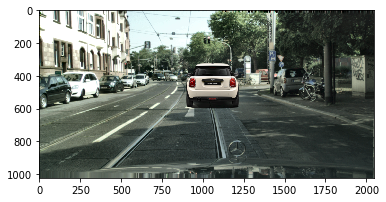

In [36]:
#__main__
road = drawCar()

cv2.imwrite("test.jpeg", road)
road = toRGB(road)
plt.imshow(road)